In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name())

True
1
0
NVIDIA GeForce RTX 2060 with Max-Q Design


In [24]:
train_dataset = torchvision.datasets.FashionMNIST('data/', download=False, train=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST('data/', download=False, train=False, transform=transforms.Compose([transforms.ToTensor()]))

In [22]:
train_dataset = torchvision.datasets.FashionMNIST('data/', download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST('data/', download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

In [25]:
train_loader = DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, shuffle=True, batch_size=100)

In [26]:
label_list = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
label_map = dict(zip(range(10), label_list))
print(label_map)

{0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'}


In [27]:
print(train_dataset)
print(test_dataset)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [8]:
len(train_dataset), type(train_dataset[0]), train_dataset[0][0].shape, train_dataset[0][0][0].shape, train_dataset[0][1]

(60000, tuple, torch.Size([1, 28, 28]), torch.Size([28, 28]), 9)

In [16]:
len(test_dataset)

10000

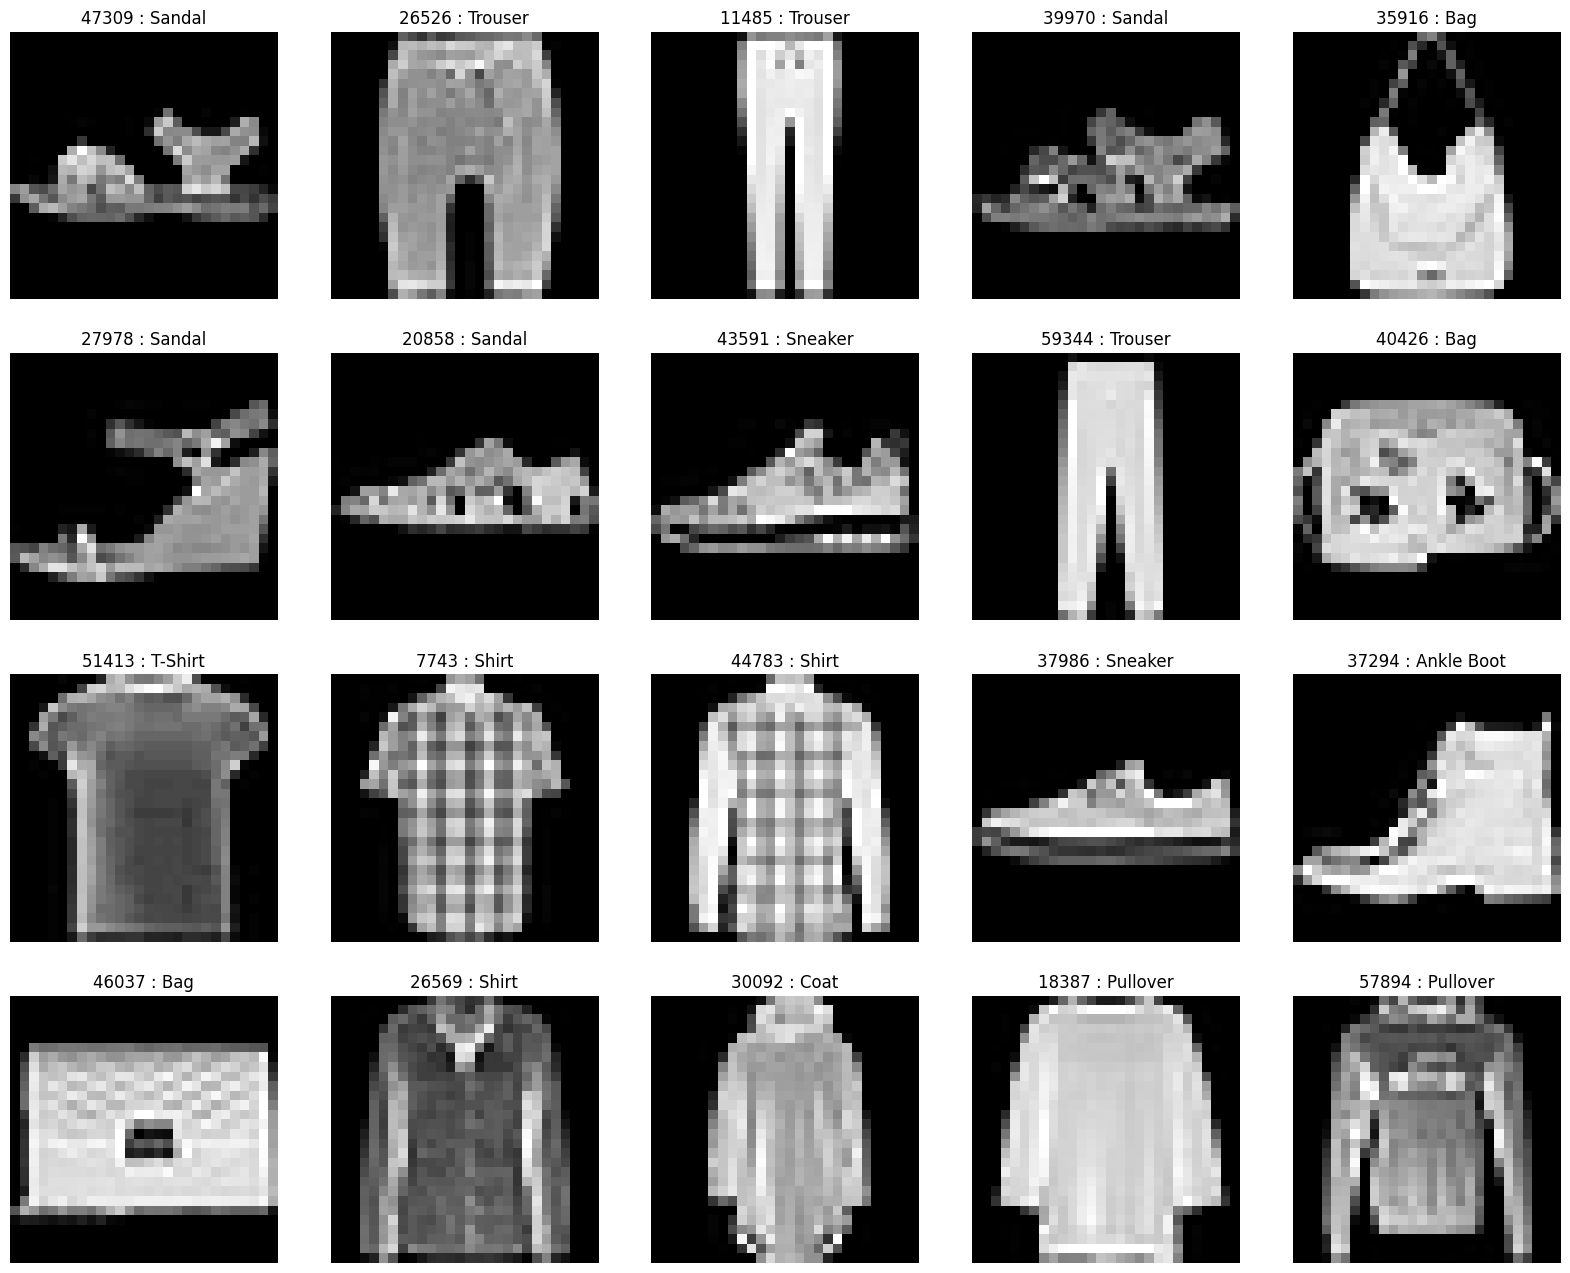

In [9]:
fig = plt.figure(figsize=(20, 16))
columns, rows = 5, 4

for i in range(1, columns*rows+1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0, :, :]
    fig.add_subplot(rows, columns, i)
    plt.title(str(img_xy) + " : " + label_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    
plt.show()

##### Deep Neural Network Model for FashionMNIST

In [14]:
# Deep Neural Network Model 생성
class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN, self).__init__()    # super().__init__()과 같다. 자식클래스(FashionDNN)가 상속받는 부모클래스(nn.Module)를 자식클래스(FashionDNN)에 불러오겠습니다.
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.drop = nn.Dropout(p=0.25)
        
    def forward(self, input_data):     # 모델이 학습데이터를 입력받아서 순전파(forward propagation)연산을 진행하는 함수이며 예측값을 출력합니다.
        out = input_data.view(-1, 28*28)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out        

In [15]:
# 파라미터 정의
learning_rate = 0.001

model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
)


In [13]:
# 모델 학습
num_epochs = 5
count = 0
loss_list, iteration_list, accuracy_list, predictions_list, labels_list = [],[],[],[],[]

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # autograd는 Variable을 이용해서 
        # 순전파단계에서는 수행하는 모든 연산을 테이프에 저장한다.
        # 역전파단계에서는 저장된 값들을 꺼내서 역전파를 위한 미분값들을 자동으로 계산해 준다.
        train = Variable(images.view(100, 1, 28, 28))   
        labels = Variable(labels)
        
        outputs = model(train)     # 학습데이터를 모델에 적용한다.
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
        
        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
                
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            
        if not (count % 500):
            print(f"Iteration: {count}, Loss: {loss.data}, Accuracy:{accuracy}")

Iteration: 500, Loss: 0.6081245541572571, Accuracy:83.22000122070312
Iteration: 1000, Loss: 0.29716959595680237, Accuracy:84.86000061035156
Iteration: 1500, Loss: 0.37893521785736084, Accuracy:86.05999755859375
Iteration: 2000, Loss: 0.31353724002838135, Accuracy:86.11000061035156
Iteration: 2500, Loss: 0.3426593840122223, Accuracy:86.18000030517578
Iteration: 3000, Loss: 0.27212876081466675, Accuracy:86.44999694824219


In [23]:
print(len(train_loader))

for img, lb in train_loader:
    img, lb = img.to(device), lb.to(device)
    tr = Variable(img.view(100, 1, 28, 28))
    lb = Variable(lb)
    
print(tr.shape)
print(lb.shape)

600
torch.Size([100, 1, 28, 28])
torch.Size([100])
